# Assignment 4: Benchmarking Neural Nets with the XOR Problem



### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
In this assignment, you will implement your own neural networks to classify non-linear data from the XOR dataset. For references, you may refer to my [lecture 13](https://docs.google.com/presentation/d/1otQfmMomWctLZKI3hHKAA4lLkbXFtagLaQov8gNh4LI/edit?usp=sharing) and [Colab Notebook 10](https://colab.research.google.com/drive/1x5biI3dP5YvvDEI0wapJcSgQNnATDzNe) if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python/Tensorflow and submit **this** Jupyter Notebook file (.ipynb) to earn a total of 100 pts. Note that you must save your Notebook filename under this format: **yourUvaUserId_assignment_4_ann.ipynb**.



In [1]:
# You might want to use the following packages
import sklearn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

---
## 1. THE DATASET AND VISUALIZATION

We will use the non-linear toy data called the XOR dataset. You may use the code snippet below to generate the train/validate/test set. Feel free to change the number of samples, and noise level. To keep the ratio between the sets consistent, please do not change the test_size and random_state parameters.



(720, 2)
(200, 2)
(80, 2)


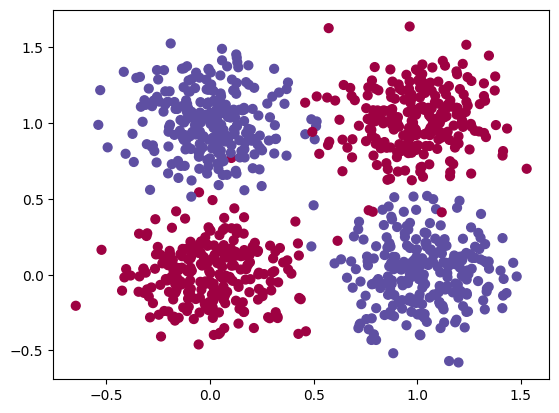

In [2]:
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers,labels):
        points = np.random.normal(loc=center,scale=0.2,size=(n_points//4,2))
        points_labels = np.hstack((points,label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data,points_labels))
    return (data[:,[0,1]],data[:,2])


X, y = make_xor(1000)
y=y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.1, random_state=49)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)


---
## 2. TRAIN A SIMPLE ANN FOR CLASSIFICATION TASK (20 pts)

Use the standard libarary of Neural Net on the training data, and then test the classifier on the test data. You will create a simple ANN with 3 layers: an Input Layer, a Hidden Layer and an Output Layer. For each layer, you can specify the number of nodes appropriate for the XOR problem. Also, you have to make attempt to tune the network to improve the model in term on classification accuracy. You have to report the accuracy of the network on the validation set.

In [43]:
import tensorflow as tf
from tensorflow import keras

my_model = keras.Sequential()
# Your code here!
my_model.add(keras.layers.Input(shape=(2,)))
my_model.add(keras.layers.Dense(4, activation='tanh')) # input shape implicitly handles input layer
my_model.add(keras.layers.Dense(2, activation='softmax'))
my_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 4)                 12        
                                                                 
 dense_8 (Dense)             (None, 2)                 10        
                                                                 
Total params: 22 (88.00 Byte)
Trainable params: 22 (88.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
my_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
# batch_size tested:
# 8: val_accuracy = 0.825
# 16: val_accuracy = 0.975
# 32: val_accuracy = 0.8375
# 64: val_accuracy = 0.7

# batch_size = 16 selected
my_model.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
45/45 [==============================] - 1s 5ms/step - loss: 0.7512 - accuracy: 0.4125 - val_loss: 0.7702 - val_accuracy: 0.4000
Epoch 2/20
45/45 [==============================] - 0s 3ms/step - loss: 0.7145 - accuracy: 0.4861 - val_loss: 0.7457 - val_accuracy: 0.4375
Epoch 3/20
45/45 [==============================] - 0s 2ms/step - loss: 0.6895 - accuracy: 0.5722 - val_loss: 0.7239 - val_accuracy: 0.5250
Epoch 4/20
45/45 [==============================] - 0s 2ms/step - loss: 0.6711 - accuracy: 0.6514 - val_loss: 0.7042 - val_accuracy: 0.5625
Epoch 5/20
45/45 [==============================] - 0s 2ms/step - loss: 0.6557 - accuracy: 0.6931 - val_loss: 0.6851 - val_accuracy: 0.5875
Epoch 6/20
45/45 [==============================] - 0s 2ms/step - loss: 0.6413 - accuracy: 0.7083 - val_loss: 0.6648 - val_accuracy: 0.6000
Epoch 7/20
45/45 [==============================] - 0s 2ms/step - loss: 0.6276 - accuracy: 0.7236 - val_loss: 0.6455 - val_accuracy: 0.6125
Epoch 8/20
45/45 [==

In [46]:
my_model.evaluate(X_test, y_test, batch_size=16)

13/13 [==============================] - 0s 2ms/step - loss: 0.4438 - accuracy: 0.9400


[0.4438026547431946, 0.9399999976158142]

- - -
## 3. IMPLEMENTING YOUR OWN SIMPLE NEURAL NETWORK (50 pts)

Now that you see how the standard library ANN performs on the XOR dataset, you will attempt to implement your own version of the neural network. To help you, a template has been created including the backpropagation. Essensially, you will get the backward gradients for free. However, please note that the backprop implementation assume usage of tanh activation for the hidden layer and softmax for the output layer. There are some subtasks which you need to implement in order to get the network to work properly.

In [17]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder

class MyNeuralNet(BaseEstimator):
    """Your implementation of a simple neural network"""

    def __init__ (self, n0, n1, n2, alpha=0.01):
        """
        @param: n0: Number of nodes in the input layer
        @param: n1: Number of nodes in the hidden layer
        @param: n2: Number of nodes in the output layer
        @param: alpha: The Learning Rate
        """

        # SUBTASK 1: Initialize the parameters to random values.
        np.random.seed(42)
        self.W1 = np.random.randn(n1, n0)
        self.b1 = np.random.randn(n1, 1)
        self.W2 = np.random.randn(n2, n1)
        self.b2 = np.random.randn(n2, 1)

        # Configure the learning rate
        self.alpha = alpha
        # One-hot encoder for labels
        self.encoder = OneHotEncoder(sparse_output=False)

    def forward_pass(self, X):
        """
        Pass the signal forward through the layers.
        @param: X: feature
        @return: A1: saved value of the output of the hidden layer
        @return: A2: activated return value of the output layer.
        """
        # SUBTASK 2: Implement Forward propagation.
        # Note: that you must implement tanh activation for the hiden layer
        # and softmax for the output layer

        Z1 = np.dot(self.W1, X) + self.b1
        A1 = np.tanh(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2
        A2 = np.exp(Z2)/np.sum(np.exp(Z2), axis=0)

        return A1, A2


    def loss(self, X, y):
        """
        Evaluate the total loss on the dataset
        @param: X: features
        @param: y: labels
        @return: L: the loss value
        """


        # SUBTASK 3: Calculate the loss using Cross-Entropy
        # You will need to return the average loss on the data
        # Hint: Use A2 to calculate the loss
        A1, A2 = self.forward_pass(X)
        # Another Hint: First, you may want to convert the lable y into a one-hot vector
        Y = self.one_hot(y)
        summed = -np.sum(Y*np.log(A2), axis=0)
        L = np.mean(summed)

        return L

    def backward_pass(self, A1, A2, X, y):
        """
        @param: X: feature
        @param: y: label
        @param: A1: saved value of the output of the hidden layer
        @param: a2: activated return value of the output layer.

        @return: dW1: the loss gradient of W1
        @return: db1: the loss gradient of b1
        @return: dW2: the loss gradient of W2
        @return: db2: the loss gradient of b2
        """

        # You DO NOT CHANGE this function, ...
        # unless you are advanced and want to use different activation function for your forward pass
        # This is an elegant partial derivative of cross entropy with softmax
        # Ref document: https://deepnotes.io/softmax-crossentropy
        m   = y.shape[0]
        dZ2 = A2 - self.one_hot(y)
        dW2 = np.dot(dZ2, A1.T)/m
        db2 = np.sum(dZ2, axis=1, keepdims=True)/m
        dZ1 = np.multiply( np.dot( self.W2.T, dZ2), 1-np.power( A1, 2))
        dW1 = np.dot(dZ1, X.T)/m
        db1 = np.sum(dZ1, axis=1, keepdims=True)/m

        return dW1, db1, dW2, db2


    def fit(self, X, y , epochs, X_val, Y_val):
        """
        Learns parameters for the neural network and returns the model.

        @param: X: the training feature
        @param: y: the train label
        @param: epochs: Number of passes through the training data for gradient descent
        @param: X_val: the feature of validation set
        @param: y_val: the label of validation set
        """

        # Input checks: X and X_val needs to be in the form of n0 x m
        if (X.shape[0] > X.shape[1]): X = X.T
        if (X_val.shape[0] > X_val.shape[1]): X_val = X_val.T

        # Gradient descent
        for i in range(0, epochs):

            # SUBTASK 4: Compute the forward, backward, and gradient descent parameter update
            # Step 1: Forward pass
            A1, A2 = self.forward_pass(X)

            # Step 2: Backward pass
            dW1, db1, dW2, db2 = self.backward_pass(A1, A2, X, y)

            # Step 3: Gradient Descent
            self.W1 = self.W1 - self.alpha * dW1
            self.b1 = self.b1 - self.alpha * db1
            self.W2 = self.W2 - self.alpha * dW2
            self.b2 = self.b2 - self.alpha * db2

            # Print the loss and validation accuracy every 10 epochs.
            if i % 10 == 0:
                print("Epoch %i/%i - loss: %f - accuracy: %f - val_loss: %f - val_accuracy: %f"
                      %(i,epochs, self.loss(X, y), self.evaluate(X, y),
                        self.loss(X_val, y_val), self.evaluate(X_val,y_val)))

    def predict(self, X):
        """
        Predict label vector y
        """
        # check X for the form of n0 x m
        if (X.shape[0] > X.shape[1]): X = X.T

        # SUBTASK 5: Implement the prediction process.
        # Hint: It should include a forward pass, and then use the class with higher probability.
        A1, A2 = self.forward_pass(X)
        y_hat = np.argmax(A2, axis=0)

        return y_hat


    def evaluate(self, X, y):
        """
        Evaluate the accuracy of the model
        """
        m = y.shape[0]
        y_hat = self.predict(X)
        correct_y = (y_hat == y).astype(int)

        return sum(correct_y)/m


    def one_hot(self, y):
        """
        Utility function: Convert a label vector to one-hot vector
        """
        Y = self.encoder.fit_transform(y.reshape(len(y),1))
        return Y.T # Transpose to get into same shape 1 x m


    def plot_decision_boundary(self, X, y):
        """
        Utility Function: Plot a decision boundary for visualization purpose.
        If you don't fully understand this function don't worry, it just generates the contour plot below.
        """
        # Set min and max values and give it some padding
        x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
        y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
        h = 0.01
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole gid
        data_grid= np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(data_grid)
        Z = Z.reshape(xx.shape)

        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)

---
## 4. REFLECT ON THE COMPARISON BETWEEN YOUR IMPLEMENTATION TO THE STANDARD LIBRARY (30 pts)
Now that you have implemented your own Neural Net class, let's use it! Create at least 3 instances of your Neural Net class, each with a different number of nodes in the hiden layer, tune it with the appropriate learning rate and number of iteration. You will test their performance in the Xor dataset and report the test accuracy metrics for each instance of your neural network.

Based on the test accuracy, compare your models with the standard library version.

Epoch 0/300 - loss: 0.704986 - accuracy: 0.651389 - val_loss: 0.793432 - val_accuracy: 0.550000
Epoch 10/300 - loss: 0.644142 - accuracy: 0.652778 - val_loss: 0.696710 - val_accuracy: 0.562500
Epoch 20/300 - loss: 0.610637 - accuracy: 0.656944 - val_loss: 0.654763 - val_accuracy: 0.537500
Epoch 30/300 - loss: 0.585834 - accuracy: 0.666667 - val_loss: 0.625729 - val_accuracy: 0.537500
Epoch 40/300 - loss: 0.565885 - accuracy: 0.694444 - val_loss: 0.602693 - val_accuracy: 0.625000
Epoch 50/300 - loss: 0.548762 - accuracy: 0.776389 - val_loss: 0.583181 - val_accuracy: 0.675000
Epoch 60/300 - loss: 0.533315 - accuracy: 0.819444 - val_loss: 0.565908 - val_accuracy: 0.775000
Epoch 70/300 - loss: 0.518871 - accuracy: 0.840278 - val_loss: 0.550103 - val_accuracy: 0.800000
Epoch 80/300 - loss: 0.505012 - accuracy: 0.866667 - val_loss: 0.535267 - val_accuracy: 0.837500
Epoch 90/300 - loss: 0.491473 - accuracy: 0.880556 - val_loss: 0.521062 - val_accuracy: 0.837500
Epoch 100/300 - loss: 0.478091 

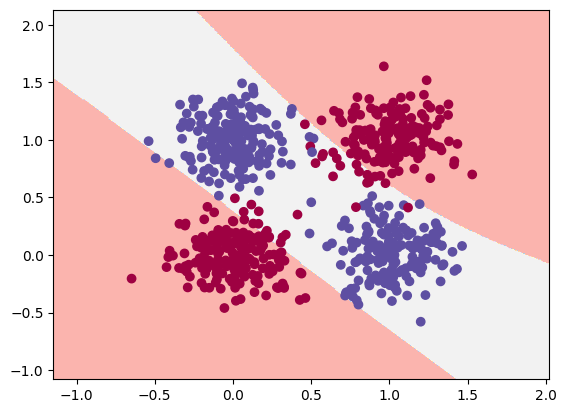

In [35]:
# MODEL 1 here
n0 = 2
n1 = 4
n2 = 2
alpha = 0.1
epochs = 300

# Build a model with 3 layers
myModel1 = MyNeuralNet(n0, n1, n2, alpha);
myModel1.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

# Plot the decision boundary
myModel1.plot_decision_boundary(X_train, y_train)


Epoch 0/300 - loss: 1.085597 - accuracy: 0.402778 - val_loss: 1.008603 - val_accuracy: 0.350000
Epoch 10/300 - loss: 0.689258 - accuracy: 0.558333 - val_loss: 0.678675 - val_accuracy: 0.525000
Epoch 20/300 - loss: 0.542361 - accuracy: 0.834722 - val_loss: 0.544962 - val_accuracy: 0.837500
Epoch 30/300 - loss: 0.460179 - accuracy: 0.927778 - val_loss: 0.465647 - val_accuracy: 0.900000
Epoch 40/300 - loss: 0.399414 - accuracy: 0.956944 - val_loss: 0.406268 - val_accuracy: 0.950000
Epoch 50/300 - loss: 0.352758 - accuracy: 0.970833 - val_loss: 0.360347 - val_accuracy: 0.950000
Epoch 60/300 - loss: 0.316700 - accuracy: 0.972222 - val_loss: 0.324751 - val_accuracy: 0.962500
Epoch 70/300 - loss: 0.288350 - accuracy: 0.979167 - val_loss: 0.296791 - val_accuracy: 0.975000
Epoch 80/300 - loss: 0.265506 - accuracy: 0.977778 - val_loss: 0.274346 - val_accuracy: 0.975000
Epoch 90/300 - loss: 0.246629 - accuracy: 0.983333 - val_loss: 0.255899 - val_accuracy: 0.975000
Epoch 100/300 - loss: 0.230678 

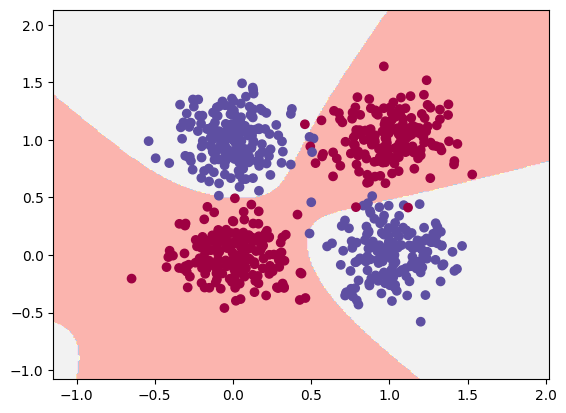

In [36]:
# MODEL 2 here
n0 = 2
n1 = 10
n2 = 2
alpha = 0.1
epochs = 300

# Build a model with 3 layers
myModel2 = MyNeuralNet(n0, n1, n2, alpha);
myModel2.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel2.evaluate(X_test, y_test))

# Plot the decision boundary
myModel2.plot_decision_boundary(X_train, y_train)

Epoch 0/100 - loss: 1.813538 - accuracy: 0.480556 - val_loss: 1.400089 - val_accuracy: 0.512500
Epoch 10/100 - loss: 0.501095 - accuracy: 0.862500 - val_loss: 0.466683 - val_accuracy: 0.887500
Epoch 20/100 - loss: 0.321373 - accuracy: 0.958333 - val_loss: 0.307899 - val_accuracy: 0.975000
Epoch 30/100 - loss: 0.243750 - accuracy: 0.973611 - val_loss: 0.240145 - val_accuracy: 0.975000
Epoch 40/100 - loss: 0.200922 - accuracy: 0.983333 - val_loss: 0.203180 - val_accuracy: 0.987500
Epoch 50/100 - loss: 0.173532 - accuracy: 0.986111 - val_loss: 0.179670 - val_accuracy: 0.975000
Epoch 60/100 - loss: 0.154326 - accuracy: 0.986111 - val_loss: 0.163215 - val_accuracy: 0.975000
Epoch 70/100 - loss: 0.140003 - accuracy: 0.984722 - val_loss: 0.150934 - val_accuracy: 0.975000
Epoch 80/100 - loss: 0.128844 - accuracy: 0.984722 - val_loss: 0.141343 - val_accuracy: 0.975000
Epoch 90/100 - loss: 0.119864 - accuracy: 0.986111 - val_loss: 0.133597 - val_accuracy: 0.975000
Accuracy on the test set is  0.

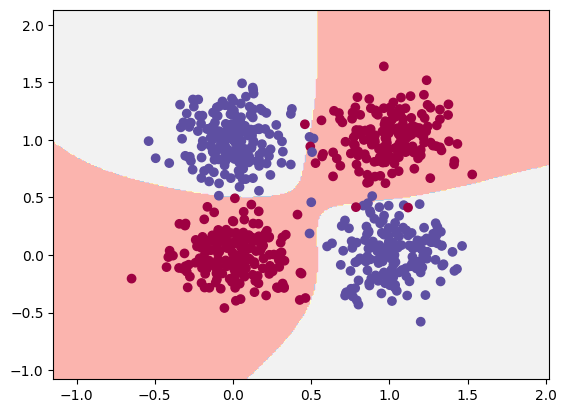

In [37]:
# MODEL 3 here
n0 = 2
n1 = 50
n2 = 2
alpha = 0.1
epochs = 300

# Build a model with 3 layers
myModel3 = MyNeuralNet(n0, n1, n2, alpha);
myModel3.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel3.evaluate(X_test, y_test))

# Plot the decision boundary
myModel3.plot_decision_boundary(X_train, y_train)

In [ ]:
# COMPARISONS WITH THE STANDARD LIBRARY

'''
with the same number of hidden layer nodes, the standard library implementation
achieved a slightly better accuracy on the test set than my implementation of the
artificial neural network (0.94 vs 0.92). With more nodes, however, my model
was able to reach a validation accuracy of 0.97 with 50 hidden layer nodes. It is
likely that if I did the same with the library implementation I would also see
similarly higher accuracy.
'''

## Reflection
Write at least a paragraph answering these prompts: How did your own network perform? Is there any major differences between the implementations? Finally, reflecting on your experience implementing a learning algorithm for this assignment (Was it hard/easy/fun?, From which part did you learn the most?)!

In [ ]:
'''
My network performed reasonably well, especially with more hidden layer nodes.
The biggest difference between the implementations is that the library
implementation allows for new and different layers to be added after initializing
the model, and different activation functions to be specified at each layer,
whereas my implementation requires all of these parameters and functions to be
directly programmed into the class. While writing the code for the learning
algorithm in this assignment, I learned the most from analyzing the backpropagation
step while working on implementing the code for the forward propagation step.
Analyzing the slides and functions, I learned a lot about the math behind how node
weights are used and changed as a neural network develops and learns to be able to
then be used for predictions when given values of features. I did not find the
experience to be unreasonably hard as a whole and found it enriching to learn
and understand a lot of what is going on in the backend of a neural network.
'''

---
# Get Help?
In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [lecture 13](https://docs.google.com/presentation/d/1otQfmMomWctLZKI3hHKAA4lLkbXFtagLaQov8gNh4LI/edit?usp=sharing) and [Colab Notebook 10](https://colab.research.google.com/drive/1x5biI3dP5YvvDEI0wapJcSgQNnATDzNe)
 * Talk to the TA, they are available and there to help you during office hour.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 4:...".

Part of the codes used in this assignment is modified from Konstantinos Kitsios under the 3-Clause BSD License. Best of luck and have fun!